In [3]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from dask.distributed import wait
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

## Spin up DASK cluster

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='30 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=30GB',
        project='NCGD0011',
        walltime='08:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient()
cluster.scale(34) 
client

Client Scheduler: tcp://128.117.208.176:34925 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/37411/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Define some functions we'll need to load data

In [6]:
# define the metrics we can load 
metrics_dict = {
    "NPP": ['photoC_TOT_zint'],
    "Zooplankton Production": ['graze_diat_zint', 'graze_sp_zint'],
    "Diatom fraction (biomass)": ['diatC', 'spC'],
    "Mesozoo production": ['graze_diat_zint', 'graze_sp_zint', 'diatC', 'spC'],
    "Mesozooplankton biomass": ['zooC', 'diatC', 'spC', 'graze_diat_zint', 'graze_sp_zint'],
    "Trophic Level 3": ['graze_diat_zint', 'graze_sp_zint', 'diatC', 'spC'],
    "Krill Growth Potential": ['TEMP','diatChl','spChl','diazChl'],
    "TEMP":['TEMP']
}

def get_metrics_list():
    return list(metrics_dict.keys())

In [7]:
# function to return the variables we need to return for all metrics
def get_metric_variable(metric):
    var_names = metrics_dict[metric]
    # handle the case where there is only one variable
    if isinstance(var_names, str):
        return var_names
    # handle the case where there are multiple variables
    else:
        return var_names[:]

In [8]:
# just grab the top layer and to keep time bound
def preprocess(ds):
    tb = ds.time_bound
    # check if relevant variables are in dataset, and if so, average over the dimension
    ds = ds.isel(z_t=0) ####################################### SST!!!
    #re-write time bound with saved value
    ds['time_bound'] = tb
    return ds

In [9]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ocn',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict(preprocess=preprocess)
        ds = dsets[f'ocn.{experiment}.pop.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bound.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['z_t','time_bound','z_t_150m','KMT','TLAT','TLONG','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [10]:
import utils

In [11]:
## Print out potential metrics to investigate:
metrics_list = get_metrics_list()
print(metrics_list)

['NPP', 'Zooplankton Production', 'Diatom fraction (biomass)', 'Mesozoo production', 'Mesozooplankton biomass', 'Trophic Level 3', 'Krill Growth Potential', 'TEMP']


In [12]:
## Enter the metric  of interest:
metric = 'TEMP'

In [13]:
## Enter the years you want to keep:
yy_st = "1920"
yy_ed = "2100"

In [14]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -50

## Load CESM2-LE data

In [15]:
# for the metric supplied, define the list of required variable names
varnames = get_metric_variable(metric) 
varnames

['TEMP']

### Load the Data Catalog

In [16]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [17]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
# preprocess if some variables need depth averaging
#ds_hist = preprocess(ds_hist)
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 17.7 s, sys: 1.24 s, total: 18.9 s
Wall time: 1min 23s


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 55, nlon: 320, time: 1980, z_t_150m: 15)
Coordinates:
    z_t         float32 500.0
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
  * time        (time) object 1850-01-16 13:00:00.000001 ... 2014-12-16 12:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 55, 320), meta=np.ndarray>
    TEMP        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 55, 320), meta=np.ndarray>

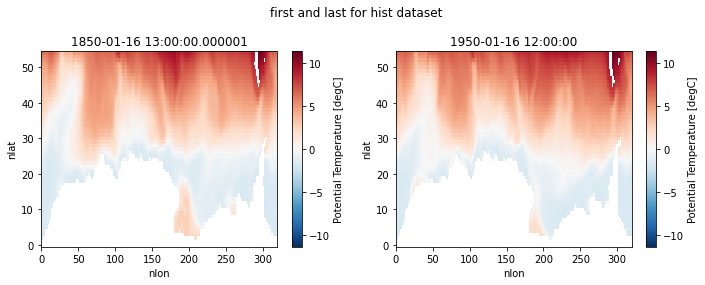

In [18]:
mem_5_hist = ds_hist.TEMP.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [19]:
%%time
# load historical
ds_ssp = load_datasets(varnames,'ssp370',lat_min,lat_max)
# preprocess if some variables need depth averaging
#ds_ssp = preprocess(ds_ssp)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 8.93 s, sys: 114 ms, total: 9.05 s
Wall time: 16.1 s


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 55, nlon: 320, time: 1032, z_t_150m: 15)
Coordinates:
    z_t         float32 500.0
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
  * time        (time) object 2015-01-16 13:00:00.000001 ... 2100-12-16 12:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 55, 320), meta=np.ndarray>
    TEMP        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 55, 320), meta=np.ndarray>

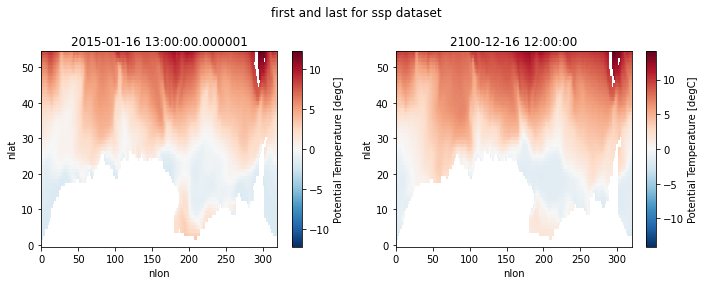

In [20]:
mem_5_ssp = ds_ssp.TEMP.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last for ssp dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets, keep just years of interest

In [21]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 13, 0, 0, 1),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
    z_t      float32 500.0
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16 12:00:00

In [22]:
ds = ds.isel(time=slice(840,3012))

In [23]:
%%time

ds = ds.load()

CPU times: user 26.1 s, sys: 6.28 s, total: 32.4 s
Wall time: 3min 59s


In [24]:
# # keep just years chosen above
# ds = ds.sel(time=slice(yy_st, yy_ed))
# #ds = ds.isel(time=slice(1200, 3012)) # Cut timeseries to 1950 - 2100: 1812 time steps
# ds.time

## Compute your metric!

In [25]:
# variable = 'KGP'

# # Drop other variables after you calculate it
# keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [variable]

# ds = ds.drop([v for v in ds.variables if v not in keep_vars])
ds

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 55, nlon: 320, time: 2172, z_t_150m: 15)
Coordinates:
    z_t         float32 500.0
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -50.37 -50.37
  * time        (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    KMT         (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 44.0 45.0 48.0
    time_bound  (time, d2, nlat, nlon) object 1920-01-01 00:00:00 ... 2101-01...
    TEMP        (member_id, time, nlat, nlon) float32 nan nan ... 8.352 8.222

# Compute Seasonal means
* Growing season = ONDJFM 
* Early Season = OND
* Late Season = JFM


In [26]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [27]:
# Dataset will become shorter because of the Jan.1 boundary for some seasons
# for 1950-2100, 150 years long (1800 time steps instead of 1812). Last year will be 2099
years = np.arange(int(yy_st),int(yy_ed)+1,1)

tlen = 181 #annual timesteps 
xlen = len(ds.nlon)
ylen = len(ds.nlat)
elen = len(ds.member_id)
print(tlen,xlen,ylen,elen)

181 320 55 50


In [28]:
# ######## make annual mean

# ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [27]:
# # Export the dataset to NetCDF with all attributes and coordinates
# ds_ann.to_netcdf('/glade/derecho/scratch/kristenk/ToE_saved_data/TEMP_100m_annual_means_1850-2100.nc')

### Compute Growing Season (ONDJFM)

In [29]:
%%time

var = 'TEMP'

ds_Oct_Mar_int = xr.Dataset()

Oct_Mar_int = np.zeros([tlen-1,elen,ylen,xlen])

for year in np.arange(0,180,1):
    print(year)
    #get october for this year
    st_mon = year*12 + 9

    #sum over oct to following year march
    i=0
    for month in [10,11,12,1,2,3]:

        if(month == 10):
            summing = ds[var].isel(time=st_mon) * days_per_month[month-1]
            tot_days = days_per_month[month-1]
        else:
            summing = summing + ds[var].isel(time=st_mon+i) * days_per_month[month-1]
            tot_days = tot_days + days_per_month[month-1]

        i = i + 1

    Oct_Mar_int[year,:,:,:] = (summing/tot_days).compute()

Oct_Mar_int = xr.DataArray(Oct_Mar_int,dims=('time','member_id','nlat','nlon'))

ds_Oct_Mar_int[var] = Oct_Mar_int

ds_Oct_Mar_int[var].attrs['units'] = 'degrees C'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
CPU times: user 1.29 s, sys: 116 ms, total: 1.4 s
Wall time: 1.48 s


In [30]:
#ds_Oct_Mar_int['time'] = years
ds_Oct_Mar_int

<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 180)
Dimensions without coordinates: member_id, nlat, nlon, time
Data variables:
    TEMP     (time, member_id, nlat, nlon) float64 nan nan nan ... 8.253 8.222

### Compute Early Season (OND)

In [32]:
%%time
ds_OND_int = xr.Dataset()

OND_int = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,181,1):

    #get october for this year
    st_mon = year*12 + 9
    print(year)
    #sum over oct to december
    i=0
    for month in [10,11,12]:

        if(month == 10):
            summing = ds[var].isel(time=st_mon) * days_per_month[month-1]
            tot_days = days_per_month[month-1]
        else:
            summing = summing + ds[var].isel(time=st_mon+i) * days_per_month[month-1]
            tot_days = tot_days + days_per_month[month-1]
        i = i + 1

    OND_int[year,:,:,:] = (summing/tot_days).compute()

OND_int = xr.DataArray(OND_int,dims=('time','member_id','nlat','nlon'))

ds_OND_int[var] = OND_int

ds_OND_int[var].attrs['units'] = 'degrees C'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
CPU times: user 731 ms, sys: 79.5 ms, total: 811 ms
Wall time: 860 ms


In [33]:
%%time
ds_OND_int['time'] = years
ds_OND_int

CPU times: user 527 µs, sys: 27 µs, total: 554 µs
Wall time: 558 µs


<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    TEMP     (time, member_id, nlat, nlon) float64 nan nan nan ... 558.6 553.7

### Compute Late Season (JFM)

In [33]:
%%time
ds_JFM_int = xr.Dataset()

JFM_int = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,181,1):
    print(year)
    #get january for this year
    st_mon = year*12 + 0

    #sum over january through march
    i=0
    for month in [1,2,3]:

        if(month == 1):
            summing = ds[var].isel(time=st_mon) * days_per_month[month-1]
            tot_days = days_per_month[month-1]
        else:
            summing = summing + ds[var].isel(time=st_mon+i) * days_per_month[month-1]
            tot_days = tot_days + days_per_month[month-1]

        i = i + 1

    JFM_int[year,:,:,:] = (summing/tot_days).compute()

JFM_int = xr.DataArray(JFM_int,dims=('time','member_id','nlat','nlon'))

ds_JFM_int[var] = JFM_int

ds_JFM_int[var].attrs['units'] = 'mmol/m2/season'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
CPU times: user 697 ms, sys: 124 ms, total: 821 ms
Wall time: 844 ms


In [34]:
ds_JFM_int['time'] = years
ds_JFM_int

<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    TEMP     (time, member_id, nlat, nlon) float64 nan nan nan ... 9.835 9.844

In [35]:
ds_JFM_int

<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    TEMP     (time, member_id, nlat, nlon) float64 nan nan nan ... 9.835 9.844

In [36]:
ds_Oct_Mar_int['time'] = np.arange(1920,2100,1)

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon) Include TLAT and TLONG as coordinates
- One netcdf per variable per time period: ONDJFM (whole growing season), OND (early), JFM (late)

In [38]:
ds_out = xr.Dataset()

#ds_out['SST_ONDJFM'] = ds_Oct_Mar_int['TEMP']
ds_out['SST_OND'] = ds_OND_int['TEMP']
ds_out['SST_JFM'] = ds_JFM_int['TEMP']

ds_out.attrs['author'] = 'Kristen Krumhardt'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly SST in the Southern Ocean from 1850 to 2099. Each variable represents SST for specific seasons: ONDJFM (whole growing season), OND (early), JFM (late)'

ds_out

<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    SST_OND  (time, member_id, nlat, nlon) float64 nan nan nan ... 7.068 6.964
    SST_JFM  (time, member_id, nlat, nlon) float64 nan nan nan ... 9.835 9.844
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-05-14
    contents:        yearly SST in the Southern Ocean from 1850 to 2099. Each...

In [39]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	member_id: (50,)
	nlat: (55,)
	nlon: (320,)
	time: (181,)
Coordinates:
	time:
		[1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045
 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059
 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073
 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087
 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098

## Export and Save

In [40]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 2.37 GB.


In [41]:
path_out = '/glade/derecho/scratch/kristenk/ToE_saved_data/'
file_out = 'CESM2-LE-SST-seasonal_avgs.nc'
fout = path_out + file_out

In [42]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout,mode='w')

In [43]:
cluster.close()

## Test if it worked

In [44]:
path =  path_out
ds_test =  xr.open_dataset(path_out+file_out, decode_times=True)

In [45]:
ds_test.info()

xarray.Dataset {
dimensions:
	member_id = 50 ;
	nlat = 55 ;
	nlon = 320 ;
	time = 181 ;

variables:
	int64 time(time) ;
	float64 SST_OND(time, member_id, nlat, nlon) ;
		SST_OND:units = degrees C ;
	float64 SST_JFM(time, member_id, nlat, nlon) ;
		SST_JFM:units = mmol/m2/season ;

// global attributes:
	:author = Kristen Krumhardt ;
	:date_processed = 2025-05-14 ;
	:contents = yearly SST in the Southern Ocean from 1850 to 2099. Each variable represents SST for specific seasons: ONDJFM (whole growing season), OND (early), JFM (late) ;
}

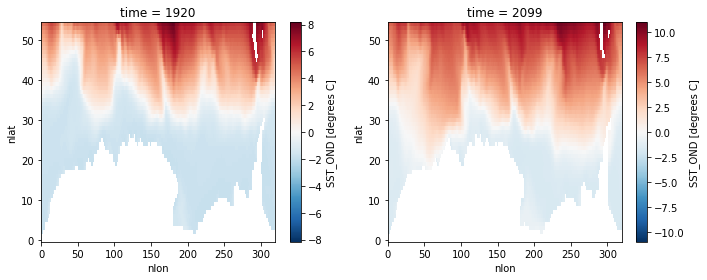

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [47]:
mem_5_ints = ds_test.SST_OND.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)
# ax1.set_title(mem_5_ints.isel(time=0).time.values)

mem_5_ints.isel(time=-2).plot(ax=ax2)
#ax2.set_title(mem_5_ints.isel(time=-1).time.values)

#fig.suptitle("first and last KGP")

plt.tight_layout()
plt.show()